# A Recommender System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import math

## 1. Dataset

In [23]:
ds = np.load('dataset.npy')

userID = ds[:,0]
itemID = ds[:,1]
rating = ds[:,2]

In [26]:
# preprocess, so userID/itemID start from 0 and there are no missing users/items
user_values = sorted(list(set(userID)))
for i,v in enumerate(user_values):
    mask = userID == v
    userID[mask] = i
    
item_values = sorted(list(set(itemID)))
for i,v in enumerate(item_values):
    mask = itemID == v
    itemID[mask] = i

In [27]:
X = np.column_stack([userID,itemID])
y = rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

userID_train = X_train[:,0]
itemID_train = X_train[:,1]
rating_train = y_train

userID_test = X_test[:,0]
itemID_test = X_test[:,1]
rating_test = y_test

## 2. Utility Matrix

In [28]:
R_train = -np.ones((len(user_values), len(item_values)))
R_train[userID_train, itemID_train] = rating_train
R_train[R_train<0] = np.nan

Text(0, 0.5, 'UserID')

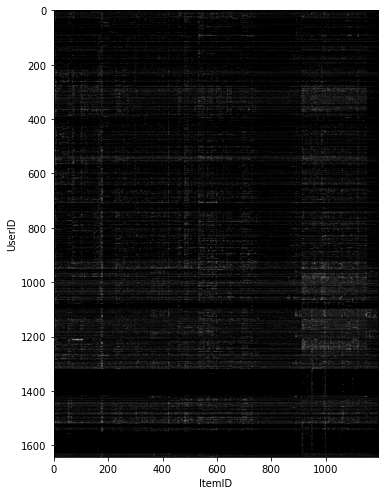

In [29]:
fs = 0.005
fig = plt.figure(figsize=(fs*R_train.shape[1], fs*R_train.shape[0]))
tmp = np.copy(R_train)
tmp[np.isnan(tmp)] = -1
plt.imshow(tmp, cmap='gray')
plt.xlabel('ItemID')
plt.ylabel('UserID')

In [31]:
def validate(recommender, userID, itemID, rating):
    preds = recommender(userID, itemID)
    return np.sqrt(np.mean((preds-rating)**2))

## Baseline

In [32]:
def recommend_naive(userID, itemID, R):
    mask = np.isnan(R)
    tmp = np.copy(R)
    tmp[mask] = 0
    user_mean = np.mean(tmp,axis=1)
    for i in range(tmp.shape[0]):
        tmp[i][mask[i]] = user_mean[i]
    
    return tmp[userID,itemID]

In [33]:
train_rmse = validate(lambda u,i: recommend_naive(u,i,R_train), userID_train, itemID_train, rating_train)
test_rmse = validate(lambda u,i: recommend_naive(u,i,R_train), userID_test, itemID_test, rating_test)
train_mse = train_rmse**2
test_mse = test_rmse**2
print(f'Train\tRMSE: {round(train_rmse,2)}\tMSE: {round(train_mse,2)}\nTest\tRMSE: {round(test_rmse,2)}\tMSE: {round(test_mse,2)}')

Train	RMSE: 0.0	MSE: 0.0
Test	RMSE: 0.87	MSE: 0.75


## Truncated SVD

In [34]:
def recommend_trunc_svd(userID, itemID, pred):
    return pred[userID,itemID]


Train	RMSE: 0.47	MSE: 0.22
Test	RMSE: 0.54	MSE: 0.29


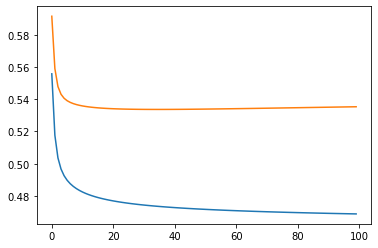

In [12]:
np.random.seed(0)
k = 10
max_it = 100

test_rmses = []
train_rmses = []

mask = np.isnan(R_train)

# initialize with user means
R_f = np.copy(R_train)
for i in range(R_f.shape[0]):
    row_mask = mask[i]
    if np.sum(~row_mask)>0:
        R_f[i][row_mask] = np.mean(R_f[i][~row_mask])
    else:
        R_f[i][row_mask] = np.mean(R_f[~mask])
    
# iterate truncated SVD
for i in tqdm(range(max_it)):
    u, s, vh = np.linalg.svd(R_f, full_matrices=False)
    pred = (u[:,:k]*s[:k])@vh[:k,:]
    R_f[mask] = pred[mask]
    train_rmse = validate(lambda u,i: recommend_trunc_svd(u,i,pred), userID_train, itemID_train, rating_train)
    test_rmse = validate(lambda u,i: recommend_trunc_svd(u,i,pred), userID_test, itemID_test, rating_test)
    test_rmses.append(test_rmse)
    train_rmses.append(train_rmse)

train_mse = train_rmse**2
test_mse = test_rmse**2
print(f'Train\tRMSE: {round(train_rmse,2)}\tMSE: {round(train_mse,2)}\nTest\tRMSE: {round(test_rmse,2)}\tMSE: {round(test_mse,2)}')

plt.plot(train_rmses)
plt.plot(test_rmses)

## Nearest Neighbour Approach

In [21]:
def recommend_kNN(userID, itemID, R, sim_matrix, k=5):
    mask = np.isnan(R)
    #recommend linear combination of nearest neighbours, that are not NaN
    idxs = np.argsort(-sim_matrix[itemID], axis=1)
    preds = []
    for idx, ui, ii in tqdm(zip(idxs, userID, itemID), total=len(userID)):
        # idx... item order
        # ui... user id
        # ii... item id
        sorted_ratings = R[ui, idx] # ratings of this user for most similar items
        tmp_mask = ~mask[ui, idx]  # which of these are not NaN?
        
        if np.sum(tmp_mask)>0:
            # kNN
            population = R[ui,idx[tmp_mask][:k]]+1 # ratings for k most similar items
            factors = population/np.sum(population)
            preds.append(np.sum(population*factors)-1)
        else:
            # no ratings at all for this user (happens in train/testsplit)
            preds.append(recommend_naive([ui], [ii], R)[0])
            #preds.append(recommend_trunc_svd([ui],[ii],pred)[0])
            
    return np.array(preds)

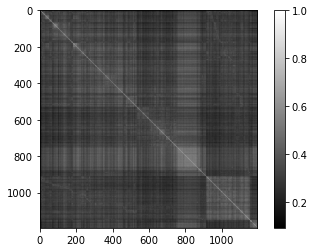

In [35]:
# Item Similarity

R_train.shape
tmp = np.copy(R_train)+1
tmp[np.isnan(R_train)] = 0
tmp /= np.linalg.norm(tmp, axis=0)
sim_matrix = tmp.T @ tmp

plt.imshow(sim_matrix, cmap='gray')
plt.colorbar()

In [18]:
train_rmse = validate(lambda u,i: recommend_kNN(u,i,R_train,sim_matrix), userID_train, itemID_train, rating_train)
test_rmse = validate(lambda u,i: recommend_kNN(u,i,R_train,sim_matrix), userID_test, itemID_test, rating_test)
train_mse = train_rmse**2
test_mse = test_rmse**2
print(f'Train\tRMSE: {round(train_rmse,2)}\tMSE: {round(train_mse,2)}\nTest\tRMSE: {round(test_rmse,2)}\tMSE: {round(test_mse,2)}')


Train	RMSE: 0.42	MSE: 0.17
Test	RMSE: 0.54	MSE: 0.29
